In [1]:
import math

def generate_primes(n: int) -> list[int]:
    is_prime = [True] * n
    is_prime[0] = is_prime[1] = False  # 0 and 1 are not prime numbers

    primes = []
    for p in range(2, n):
        if is_prime[p]:
            primes.append(p)
            # Mark all multiples of p as not prime
            for i in range(p * p, n, p):
                is_prime[i] = False
    return primes

limit = 5000000
prime_list = generate_primes(limit)

# print(f"List of primes less than {limit}:", prime_list)
print(f"Number of primes less than {limit}:", len(prime_list))

Number of primes less than 5000000: 348513


In [2]:
import numpy as np
from numba import njit
import tqdm

# Find the number of the mod-p solutions to the equation y^2 = x^3 + ax + b
@njit
def count_solutions_elliptic_curve(a, b, p):
    v_x = np.arange(p)
    v_x = (v_x ** 3 + a * v_x + b) % p
    res_x = np.bincount(v_x, minlength = p)
    
    v_y = np.arange(p)
    v_y = (v_y ** 2) % p
    res_y = np.bincount(v_y, minlength = p)
    return sum(res_x * res_y)

#    v_x = [0] * p
#    for x in range(p):
#         rhs = (x**3 + a*x + b) % p
#         v_x[rhs] += 1
    
#     v = [0] * p
#     for y in range(p):
#         lhs = (y**2) % p
#         v[lhs] += v_x[lhs] 
#     return sum(v)

data = []
for prime in tqdm.tqdm(prime_list):
    sols = count_solutions_elliptic_curve(-1, 0, prime)
    error = (prime + 1 - sols) / (2 * pow(prime, (1/2)))
    if error < -1:
        error = -1
    if error > 1:
        error = 1
    angle = math.acos(error)
    data.append((prime, sols, error, angle))

# print("[prime, number of solutions of y^2 = x^3 - x mod prime, error, angle]:", data)

100%|█████████████████████████████████| 348513/348513 [4:03:22<00:00, 23.87it/s]


In [1]:
import json
data = json.load(open("data.json"))

In [2]:
len(data)

348513

In [3]:
import math
import numpy as np
# from numba import njit
import tqdm

# def count_prime_with_bounded_error(r):
#     count = 0
#     for prime, sols, error, angle in data:        
#         if angle <= r:
#             count += 1
#     return count

def bisect(array: list[float], r: float) -> int:
    # array: sorted list of floats
    # r: float number to search for
    a, b = 0, len(array)
    while b - a > 1:
        mid = (a + b) // 2
        if r >= array[mid]:
            a = mid
        else:
            b = mid
    
    assert b - a > 0
        
    return b

sorted_data = sorted(data, key=lambda x: x[3])

num = 5000
data_to_process = []
for r in tqdm.tqdm(np.linspace(0, math.pi, num + 1)):
    e = - math.sin(r) * math.cos(r)
#     data_to_process.append((r, 1/math.pi * (r + e), count_prime_with_bounded_error(r)/len(prime_list)))
    data_to_process.append((r, 1/math.pi * (r + e), bisect([d[3] for d in sorted_data], r)/len(data)))


import pandas as pd

columns = ['Right', 'Tot', 'Target']
df = pd.DataFrame(data_to_process, columns=columns)

print(df)

100%|███████████████████████████████████████| 5001/5001 [02:17<00:00, 36.50it/s]


         Right           Tot    Target
0     0.000000  0.000000e+00  0.022022
1     0.000628  5.263789e-11  0.022022
2     0.001257  4.211030e-10  0.022022
3     0.001885  1.421222e-09  0.022022
4     0.002513  3.368821e-09  0.022022
...        ...           ...       ...
4996  3.139079  1.000000e+00  0.978821
4997  3.139708  1.000000e+00  0.978821
4998  3.140336  1.000000e+00  0.978821
4999  3.140964  1.000000e+00  0.978821
5000  3.141593  1.000000e+00  1.000000

[5001 rows x 3 columns]


In [4]:
df.describe()

,Right,Tot,Target
count,5001.000000,5001.000000,5001.000000
mean,1.570796,0.500000,0.500166
std,0.907172,0.383026,0.382574
min,0.000000,0.000000,0.022022
25%,0.785398,0.090845,0.082307
50%,1.570796,0.500000,0.512968
75%,2.356194,0.909155,0.918637
max,3.141593,1.000000,1.000000


Linear Regression Mean Squared Error (MSE): 0.0006670354643961319
R-squared (R2) Score: 0.9955321207317656


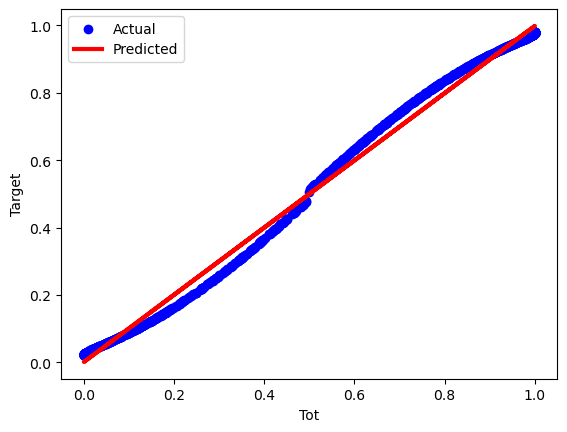

In [5]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

X = df[['Tot']]  
y = df['Target'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


from sklearn.linear_model import LinearRegression

linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)

y_pred_linear = linear_reg.predict(X_test)

mse_linear = mean_squared_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)
print(f"Linear Regression Mean Squared Error (MSE): {mse_linear}")
print(f"R-squared (R2) Score: {r2_linear}")

plt.scatter(X_test, y_test, color='blue', label='Actual')
plt.plot(X_test, y_pred_linear, linewidth=3, color='red', label='Predicted')
plt.xlabel('Tot')
plt.ylabel('Target')
plt.legend()
plt.show()

In [6]:
slope_linear = linear_reg.coef_
intercept_linear = linear_reg.intercept_

print("Linear Regression Coefficient:", slope_linear[0])
print("Linear Regression Intercept", intercept_linear)

Linear Regression Coefficient: 0.9969405619575009
Linear Regression Intercept 0.0013404546535118467


In [7]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline

# Set the range of polynomial degrees to consider
degrees = np.arange(1, 100)

# Perform k-fold cross-validation for each degree
k_folds = 5
cv_scores = []
poly_mse = []

for degree in degrees:
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_test, y_test, cv=kf, scoring='neg_mean_squared_error')
    cv_scores.append(-scores.mean())  # Take the mean of the negative mean squared errors
    poly_mse.append([degree, -scores.mean()])

# print("[degree, average MSE]:", poly_mse)

# Find the degree with the lowest cross-validation error
best_degree = degrees[np.argmin(cv_scores)]
print(f"\nThe best degree of polynomial features is {best_degree} with average MSE {poly_mse[best_degree][1]}")


The best degree of polynomial features is 63 with average MSE 1.944537883802595e-06


Polynomial Regression of degree 63 MSE: 2.0311126720824846e-06
R-squared (R2) Score: 0.9999863953767327


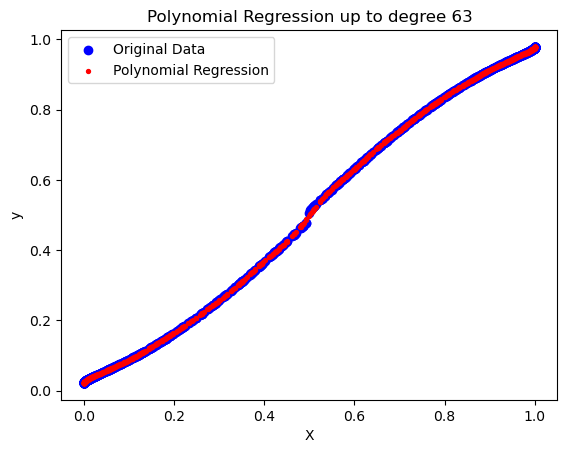

In [8]:
# Train the final model with the best degree
final_poly_reg = make_pipeline(PolynomialFeatures(best_degree), LinearRegression())
final_poly_reg.fit(X_train, y_train)

y_pred_poly = final_poly_reg.predict(X_test)

mse_poly = mean_squared_error(y_test, y_pred_poly)
r2_poly = r2_score(y_test, y_pred_poly)
print(f"Polynomial Regression of degree {best_degree} MSE: {mse_poly}")
print(f"R-squared (R2) Score: {r2_poly}")

# Plot the original data and the polynomial regression model
plt.scatter(X_test, y_test, color='blue', label='Original Data')
plt.scatter(X_test, y_pred_poly, s=8, color='red', label='Polynomial Regression')
plt.title(f"Polynomial Regression up to degree {best_degree}")
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()

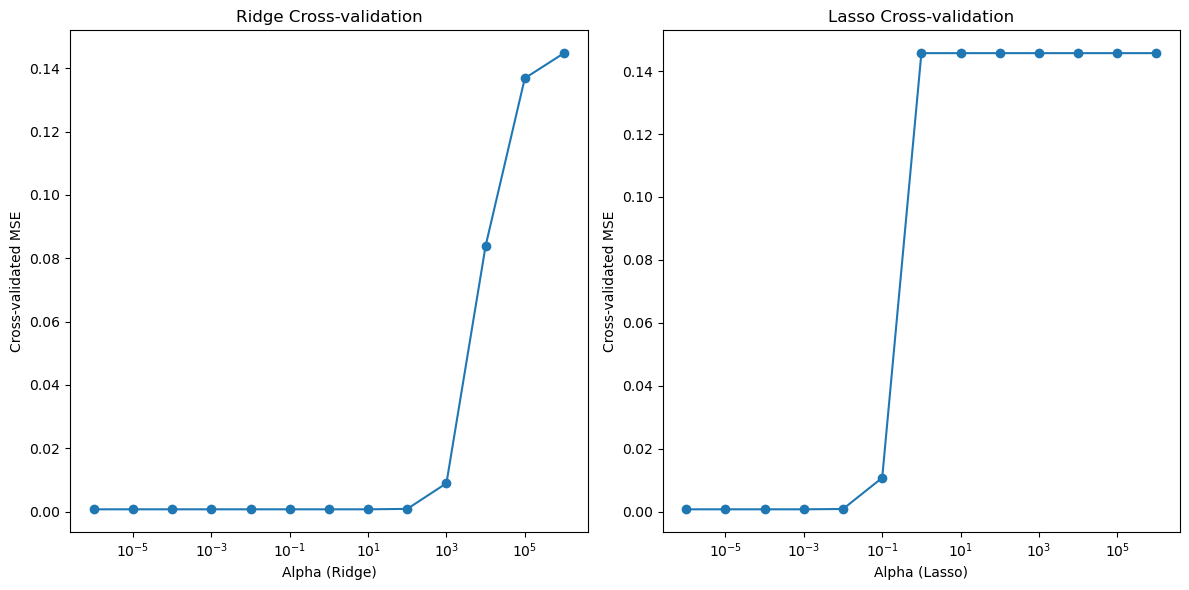

In [9]:
from sklearn.linear_model import Lasso, Ridge

# Standardize the features
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

# Define a range of alpha values for regularization strength
alphas = np.logspace(-6, 6, 13)

# Cross-validation for Ridge regression
ridge_scores = []
for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    scores = cross_val_score(ridge, X_train_std, y_train, cv=5, scoring='neg_mean_squared_error')
    ridge_scores.append(-np.mean(scores))

# Cross-validation for Lasso regression
lasso_scores = []
for alpha in alphas:
    lasso = Lasso(alpha=alpha)
    scores = cross_val_score(lasso, X_train_std, y_train, cv=5, scoring='neg_mean_squared_error')
    lasso_scores.append(-np.mean(scores))

# Plot the results
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(alphas, ridge_scores, marker='o')
plt.xscale('log')
plt.xlabel('Alpha (Ridge)')
plt.ylabel('Cross-validated MSE')
plt.title('Ridge Cross-validation')

plt.subplot(1, 2, 2)
plt.plot(alphas, lasso_scores, marker='o')
plt.xscale('log')
plt.xlabel('Alpha (Lasso)')
plt.ylabel('Cross-validated MSE')
plt.title('Lasso Cross-validation')

plt.tight_layout()
plt.show()

Ridge Regression MSE: 0.0006670234302955888
Lasso Regression MSE: 0.0013257623216087725


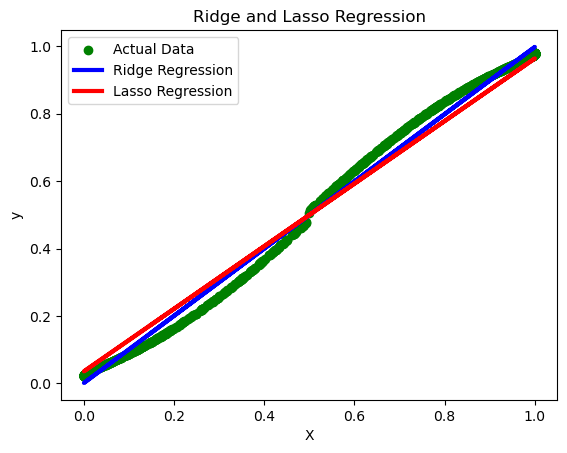

In [10]:
# from sklearn.linear_model import Ridge, Lasso

# Ridge Regression
alpha_ridge = 0.01  # Regularization strength (hyperparameter)

ridge_reg = Ridge(alpha=alpha_ridge)
ridge_reg.fit(X_train, y_train)

# Lasso Regression
alpha_lasso = 0.01  # Regularization strength (hyperparameter)

lasso_reg = Lasso(alpha=alpha_lasso)
lasso_reg.fit(X_train, y_train)

# Predictions
y_pred_ridge = ridge_reg.predict(X_test)
y_pred_lasso = lasso_reg.predict(X_test)

# Evaluate the models
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)

print("Ridge Regression MSE:", mse_ridge)
print("Lasso Regression MSE:", mse_lasso)

# Plot the results
plt.scatter(X_test, y_test, color='green', label='Actual Data')
plt.plot(X_test, y_pred_ridge, linewidth=3, color='blue', label='Ridge Regression')
plt.plot(X_test, y_pred_lasso, linewidth=3, color='red', label='Lasso Regression')
plt.title('Ridge and Lasso Regression')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()

In [11]:
# Get the slope (coefficient) for Ridge regression
slope_ridge = ridge_reg.coef_
intercept_ridge = ridge_reg.intercept_

print("Ridge Regression Coefficient:", slope_ridge[0])
print("Ridge Regression Intercept:", intercept_ridge)

# Get the slope (coefficient) for Lasso regression
slope_lasso = lasso_reg.coef_
intercept_lasso = lasso_reg.intercept_

print("Lasso Regression Coefficient:", slope_lasso[0])
print("Lasso Regression Intercept:", intercept_lasso)

Ridge Regression Coefficient: 0.9969234655418675
Ridge Regression Intercept: 0.0013490301728483756
Lasso Regression Coefficient: 0.9283438593190358
Lasso Regression Intercept: 0.0357483891885752


Learning Rate: 0.001, Average MSE: 0.11943259767141032
Learning Rate: 0.01, Average MSE: 0.019815372783428386
Learning Rate: 0.1, Average MSE: 3.273110405763087e-06
Learning Rate: 0.2, Average MSE: 4.735349884737178e-06
Learning Rate: 0.5, Average MSE: 1.59878703341797e-06
Learning Rate: 1, Average MSE: 1.0584044607527664e-06
Learning Rate: 2, Average MSE: 0.14571008388895348

Best Learning Rate: 1
Gradient Boosting Regression MSE: 1.3731132311644568e-06
R-squared (R2) Score: 0.9999908027316898


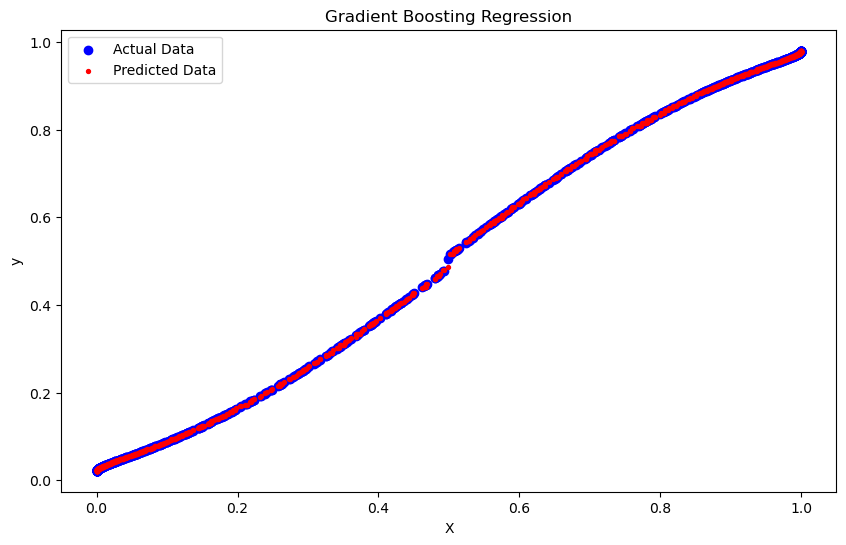

In [12]:
from sklearn.ensemble import GradientBoostingRegressor

# Define a range of learning rates
learning_rates = [0.001, 0.01, 0.1, 0.2, 0.5, 1, 2]

# Cross-validation for Gradient Boosted Regressor with different learning rates
avg_mse = []
for learning_rate in learning_rates:
    gb_regressor = GradientBoostingRegressor(learning_rate=learning_rate, random_state=42)
    scores = cross_val_score(gb_regressor, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    avg_score = -np.mean(scores)
    avg_mse.append(avg_score)
    print(f"Learning Rate: {learning_rate}, Average MSE: {avg_score}")

# Choose the learning rate with the best performance
best_learning_rate = learning_rates[np.argmin(avg_mse)]
print(f"\nBest Learning Rate: {best_learning_rate}")

# Train the final model using the best learning rate on the entire training set
final_gb_regressor = GradientBoostingRegressor(learning_rate=best_learning_rate, random_state=42)
final_gb_regressor.fit(X_train, y_train)
y_pred_fgb = final_gb_regressor.predict(X_test)

mse_fgb = mean_squared_error(y_test, y_pred_fgb)
r2_fgb = r2_score(y_test, y_pred_fgb)  # = final_gb_regressor.score(X_test, y_test)

print("Gradient Boosting Regression MSE:", mse_fgb)
print("R-squared (R2) Score:", r2_fgb)

plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, color='blue', label='Actual Data')
plt.scatter(X_test, y_pred_fgb, s=8, color='red', label='Predicted Data')
plt.title("Gradient Boosting Regression")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.show()

4/4 [==============================] - 0s 531us/step


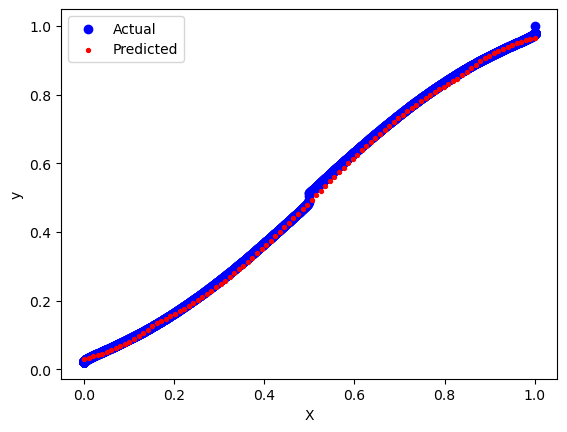

In [13]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(1,)),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid') 
])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])

model.fit(X, y, epochs=100, batch_size=16, verbose=0)

X_test_tf = np.linspace(0, 1, 100)
y_pred_tf = model.predict(X_test_tf)

plt.scatter(X, y, color='blue', label='Actual')
plt.scatter(X_test_tf, y_pred_tf, s=8, color='red', label='Predicted')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()

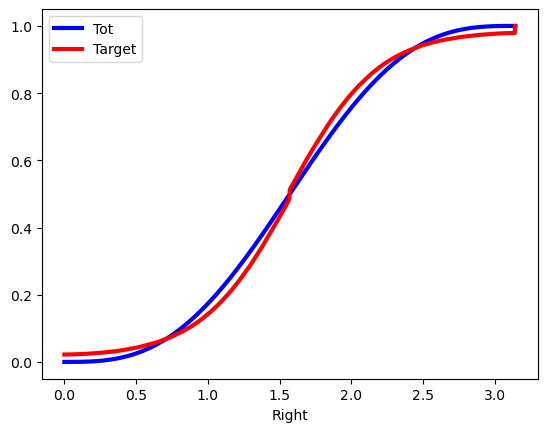

In [14]:
import matplotlib.pyplot as plt

x = df['Right'][0::5]
y_tot = df['Tot'][0::5]
y_target = df['Target'][0::5]

# Plot Tot and Target as functions of Right, which are cumulative distribution functions
plt.plot(x, y_tot, color='blue', linewidth=3, label='Tot')
plt.plot(x, y_target, color='red', linewidth=3, label='Target')
plt.xlabel("Right")
plt.legend()
plt.show()

In [15]:
def p(D: float, n: int) -> float:  # p-value
# D: ks2_samp statistic, positive number
# n: sample size
    return 2 * math.exp(- n * pow(D,2))

def cdf_ks2(data_1, data_2):
# Statistic and p-value of two-sample Kolmogorov–Smirnov test assuming samples come from cumulative distributions
# Samples have the same size
    if len(data_1) == len(data_2):
        statistic = max(abs(data_1 - data_2))
        return statistic, p(statistic, len(data_1))
    else:
        print("Input samples are not of the same size")
                        
ks_2samp_statistic, p_value = cdf_ks2(y_tot, y_target)

print(f"Two-sample Kolmogorov-Smirnov Statistic: {ks_2samp_statistic}")
print(f"P-value: {p_value}")

# Compare the p-value to the significance level (e.g., 0.05) to make a decision
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: The two samples come from different distributions.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference between the two samples.")
                        
def crit(x: float, n: int) -> float: #critical value
# x: level of significance
# n: sample size
    return math.sqrt(- 1/2 * math.log(x/2)) * math.sqrt(2/n)

critical = crit(alpha, len(y_target))
print(f"\nCritical value at the signaficance level {alpha} is {critical}")

if ks_2samp_statistic > critical:
    print("Reject the null hypothesis: The two samples come from different distributions.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference between the two samples.")

Two-sample Kolmogorov-Smirnov Statistic: 0.042640338650336285
P-value: 0.3240460971564823
Fail to reject the null hypothesis: There is no significant difference between the two samples.

Critical value at the signaficance level 0.05 is 0.060705800874826465
Fail to reject the null hypothesis: There is no significant difference between the two samples.


In [16]:
from scipy.stats import kstest, norm

x_sample = np.asarray([(a + b)/2 for a, b in zip(x[:-1], x[1:])])
pmf = np.asarray([b - a for a,b in zip(y_target[:-1], y_target[1:])])

x_mean = sum(x_sample * pmf)
x_std = math.sqrt(sum((x_sample - x_mean) * (x_sample - x_mean) * pmf))
standard_x = (x_sample - x_mean) / x_std

statistic, p = kstest(standard_x, norm().cdf)

print(f"Kolmogorov-Smirnov Statistic: {statistic}")
print(f"P-value: {p}")

# Compare the p-value to the significance level (e.g., 0.05) to make a decision
alpha = 0.05
if p < alpha:
    print("Reject the null hypothesis: The sample does not follow the normal distribution.")
else:
    print("Fail to reject the null hypothesis: The sample follows the normal distribution.")

Kolmogorov-Smirnov Statistic: 0.1786089062678925
P-value: 2.2194418348147064e-28
Reject the null hypothesis: The sample does not follow the normal distribution.


In [17]:
print(f"Target Mean {x_mean} and Target Standard Deviation {x_std}")

Target Mean 1.570254136073381 and Target Standard Deviation 0.544393019372421
